# DIVAnd multivariate - Jacobian approach
This notebook shows a synthetic example of how the _multivariate_ analysis implemented in `DIVAnd`  works.<br>
Here the so-called Jacobian approach is used, while in [`DIVAndmultivar`](DIVAndmultivar.ipynb) the EOF approach is demonstrated.
## Packages

In [1]:
using DIVAnd
using Makie, CairoMakie
using LinearAlgebra
using Statistics

## Create synthetic observations

In [2]:
ND = 559
NX = 200
NY = 250
NV = 2
len = 0.2
# obs. error variance normalized by the background error variance
epsilon2 = 1.0;

# function to interpolate
fun(x, y, v) = 2 * (sin.(6x) * cos.(6y)) * (1.5 - v) .+ (v .- 1.0) .* x .* y

fun (generic function with 1 method)

### Observations

In [3]:
x = 0.5 .+ 0.25 .* randn(ND);
y = 0.5 .+ 0.25 .* randn(ND);
v = mod.(rand(Int, ND), 20) .+ 1
v[v.>1.3] .= 2

x[v.>1.5] .+= 0.2
x[v.<1.5] .+= -0.2
f = fun.(x, y, v) + 0.2 * randn(ND)
# final grid
xi, yi, vi = ndgrid(range(0, stop = 1, length = NX), range(0, stop = 1, length = NY), 1:2);

# reference field
fref = fun.(xi, yi, vi)

# all points are valid points
mask = trues(size(xi));

mask[10:30, 20:50, :] .= false

# this problem has a simple cartesian metric
# pm is the inverse of the resolution along the 1st dimension
# pn is the inverse of the resolution along the 2nd dimension

pm = ones(size(xi)) / (xi[2, 1, 1] - xi[1, 1, 1]);
pn = ones(size(xi)) / (yi[1, 2, 1] - yi[1, 1, 1]);
pv = ones(size(xi)) / (vi[1, 1, 2] - vi[1, 1, 1]);

In [4]:
# fi is the interpolated field
@time fi, s =
    DIVAndrun(mask, (pm, pn, pv), (xi, yi, vi), (x, y, v), f, (len, len, 0.0), epsilon2);

 32.862474 seconds (34.43 M allocations: 3.011 GiB, 10.04% gc time, 89.94% compilation time)


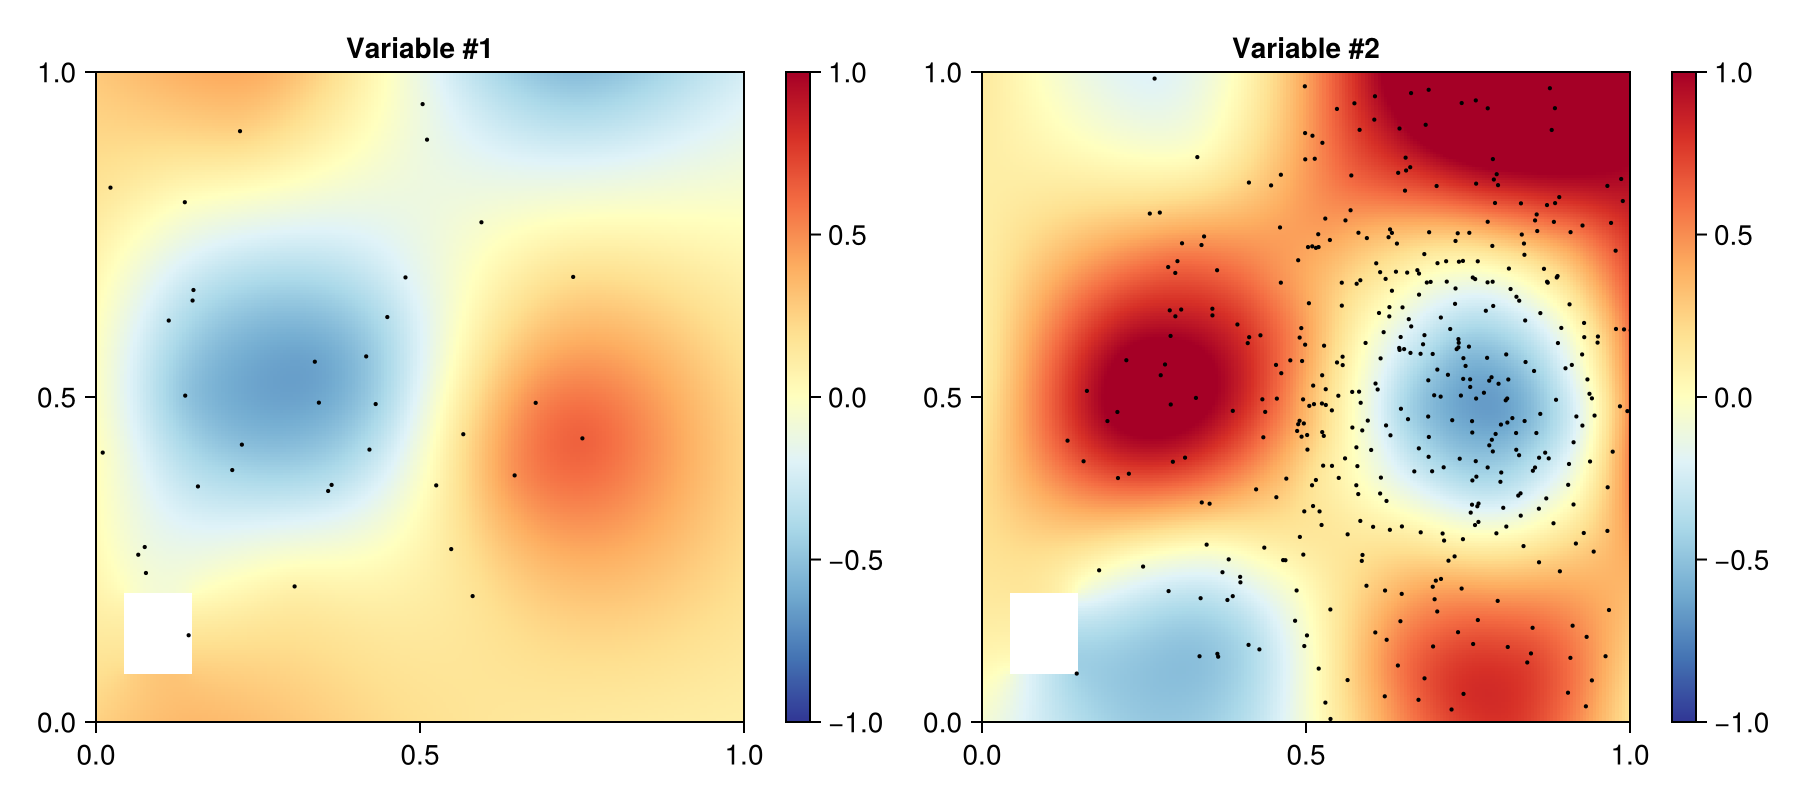

In [5]:
fig = Figure(size = (900, 400))
ax = Axis(fig[1, 1], aspect = 1, title = "Variable #1")
hm = heatmap!(
    ax,
    xi[:, 1, 1],
    yi[1, :, 1],
    fi[:, :, 1],
    colorrange = [-1, 1],
    colormap = Reverse(:RdYlBu),
)
scatter!(ax, x[v.<1.5], y[v.<1.5], color = :black, markersize = 3)
xlims!(ax, 0, 1)
ylims!(ax, 0, 1)
Colorbar(fig[1, 2], hm)

ax2 = Axis(fig[1, 3], aspect = 1, title = "Variable #2")
hm2 = heatmap!(
    ax2,
    xi[:, 1, 2],
    yi[1, :, 2],
    fi[:, :, 2],
    colorrange = [-1, 1],
    colormap = Reverse(:RdYlBu),
)
scatter!(ax2, x[v.>1.5], y[v.>1.5], color = :black, markersize = 3)
Colorbar(fig[1, 4], hm2)
xlims!(ax2, 0, 1)
ylims!(ax2, 0, 1)
fig

In [6]:
len = 0.2 * ones(Float64, size(mask));

In [7]:
@time fim, s, emap, emapm, pv = DIVAnd_multivarJAC(
    mask,
    (pm, pn, pv),
    (xi, yi, vi),
    (x, y, v),
    f,
    (len, len, 0.0 .* len),
    epsilon2;
    epsilon2jacobian = (1.0, 10.0),
);

eps2jac = (1.0, 10.0)
"error method in multivar $(meth)" = "error method in multivar scpme"
methm = :scpme
 39.126734 seconds (45.31 M allocations: 14.863 GiB, 17.16% gc time, 67.42% compilation time)


### Plot the 2 variables

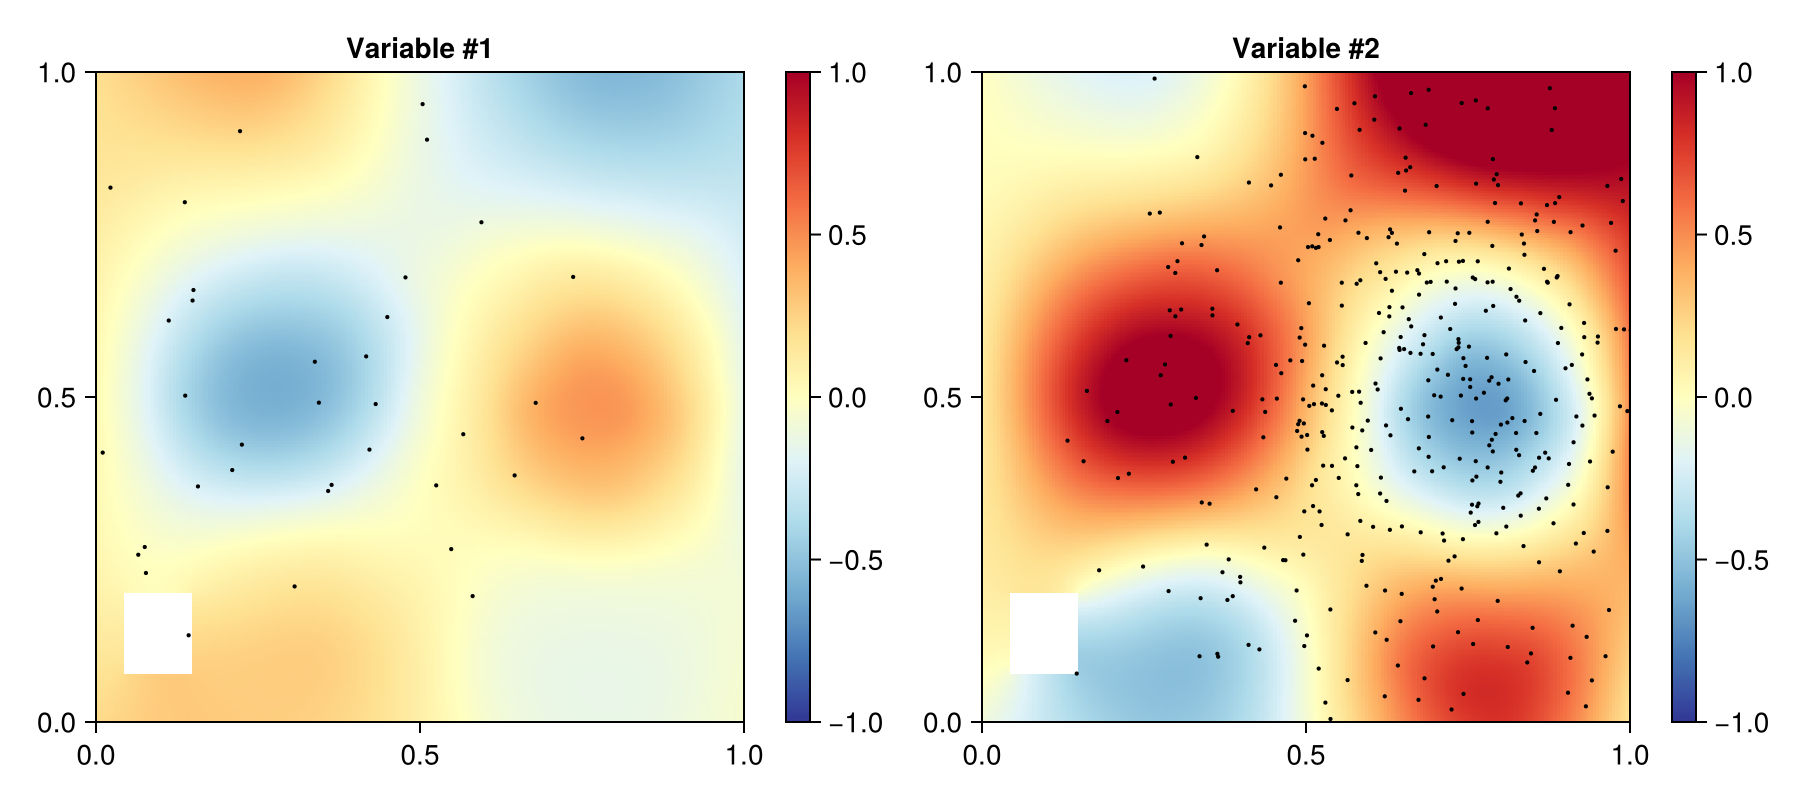

In [8]:
fig = Figure(size = (900, 400))
ax = Axis(fig[1, 1], aspect = 1, title = "Variable #1")
hm = heatmap!(
    ax,
    xi[:, 1, 1],
    yi[1, :, 1],
    fim[:, :, 1],
    colorrange = [-1, 1],
    colormap = Reverse(:RdYlBu),
)
scatter!(ax, x[v.<1.5], y[v.<1.5], color = :black, markersize = 3)
xlims!(ax, 0, 1)
ylims!(ax, 0, 1)
Colorbar(fig[1, 2], hm)

ax2 = Axis(fig[1, 3], aspect = 1, title = "Variable #2")
hm2 = heatmap!(
    ax2,
    xi[:, 1, 2],
    yi[1, :, 2],
    fim[:, :, 2],
    colorrange = [-1, 1],
    colormap = Reverse(:RdYlBu),
)
scatter!(ax2, x[v.>1.5], y[v.>1.5], color = :black, markersize = 3)
Colorbar(fig[1, 4], hm2)
xlims!(ax2, 0, 1)
ylims!(ax2, 0, 1)
fig

## Compute some statistics

In [9]:
function nanvar(f)
    return var(f[.!isnan.(f)])
end

@show nanvar(fi - fref), nanvar(fim - fref)
@show nanvar(fim[:, :, 1] - fref[:, :, 1])
@show nanvar(fi[:, :, 1] - fref[:, :, 1])
@show nanvar(fim[:, :, 2] - fref[:, :, 2])
@show nanvar(fi[:, :, 2] - fref[:, :, 2])

(nanvar(fi - fref), nanvar(fim - fref)) = (0.06820277318622626, 0.057214483004054295)
nanvar(fim[:, :, 1] - fref[:, :, 1]) = 0.09621209861932097
nanvar(fi[:, :, 1] - fref[:, :, 1]) = 0.11925554411175819
nanvar(fim[:, :, 2] - fref[:, :, 2]) = 0.01601618252248465
nanvar(fi[:, :, 2] - fref[:, :, 2]) = 0.017147683067414363


0.017147683067414363

In [10]:
@show extrema(fref), extrema(f), extrema(fi), extrema(fim)

(extrema(fref), extrema(f), extrema(fi), extrema(fim)) = ((-0.9999956276918577, 1.7600673347451958), (-1.2341898169635457, 1.9948460769481215), (NaN, NaN), (NaN, NaN))


((-0.9999956276918577, 1.7600673347451958), (-1.2341898169635457, 1.9948460769481215), (NaN, NaN), (NaN, NaN))

## Error fields

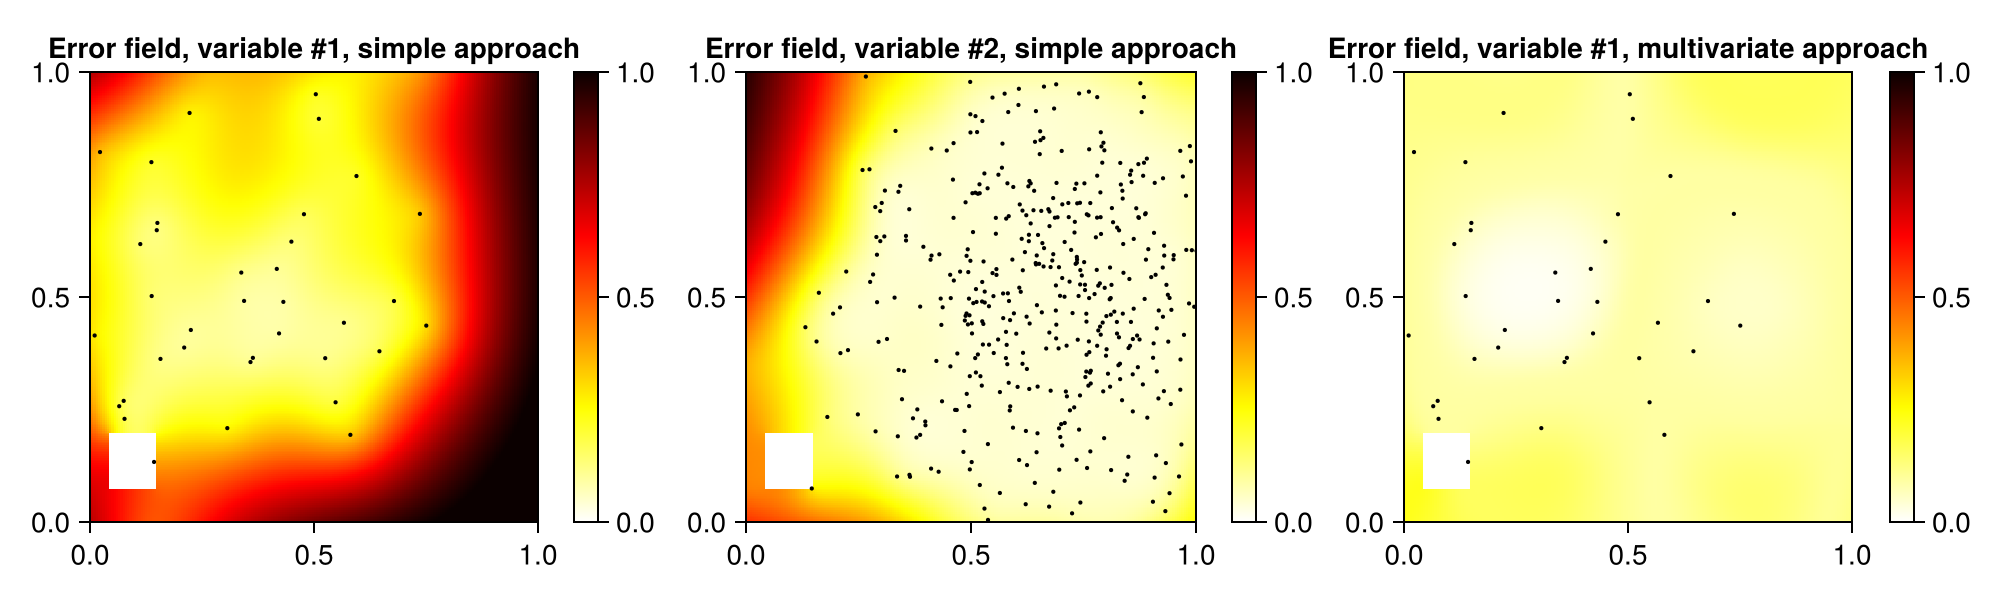

In [11]:
fig = Figure(size = (1000, 300))
ax = Axis(fig[1, 1], aspect = 1, title = "Error field, variable #1, simple approach")
hm = heatmap!(
    ax,
    xi[:, 1, 1],
    yi[1, :, 1],
    emap[:, :, 1],
    colorrange = [0, 1],
    colormap = Reverse(:hot),
)
scatter!(ax, x[v.<1.5], y[v.<1.5], color = :black, markersize = 3)
xlims!(ax, 0, 1)
ylims!(ax, 0, 1)
Colorbar(fig[1, 2], hm)

ax2 = Axis(fig[1, 3], aspect = 1, title = "Error field, variable #2, simple approach")
hm2 = heatmap!(
    ax2,
    xi[:, 1, 2],
    yi[1, :, 2],
    emap[:, :, 2],
    colorrange = [0, 1],
    colormap = Reverse(:hot),
)
scatter!(ax2, x[v.>1.5], y[v.>1.5], color = :black, markersize = 3)
Colorbar(fig[1, 4], hm2)
xlims!(ax2, 0, 1)
ylims!(ax2, 0, 1)

ax3 = Axis(fig[1, 5], aspect = 1, title = "Error field, variable #1, multivariate approach")
hm3 = heatmap!(
    ax3,
    xi[:, 1, 1],
    yi[1, :, 1],
    emapm[:, :, 1],
    colorrange = [0, 1],
    colormap = Reverse(:hot),
)
scatter!(ax3, x[v.<1.5], y[v.<1.5], color = :black, markersize = 3)
Colorbar(fig[1, 6], hm3)
xlims!(ax3, 0, 1)
ylims!(ax3, 0, 1)

fig

In [12]:
@show var(emap - emapm), var(emap)

(var(emap - emapm), var(emap)) = (NaN, NaN)


(NaN, NaN)

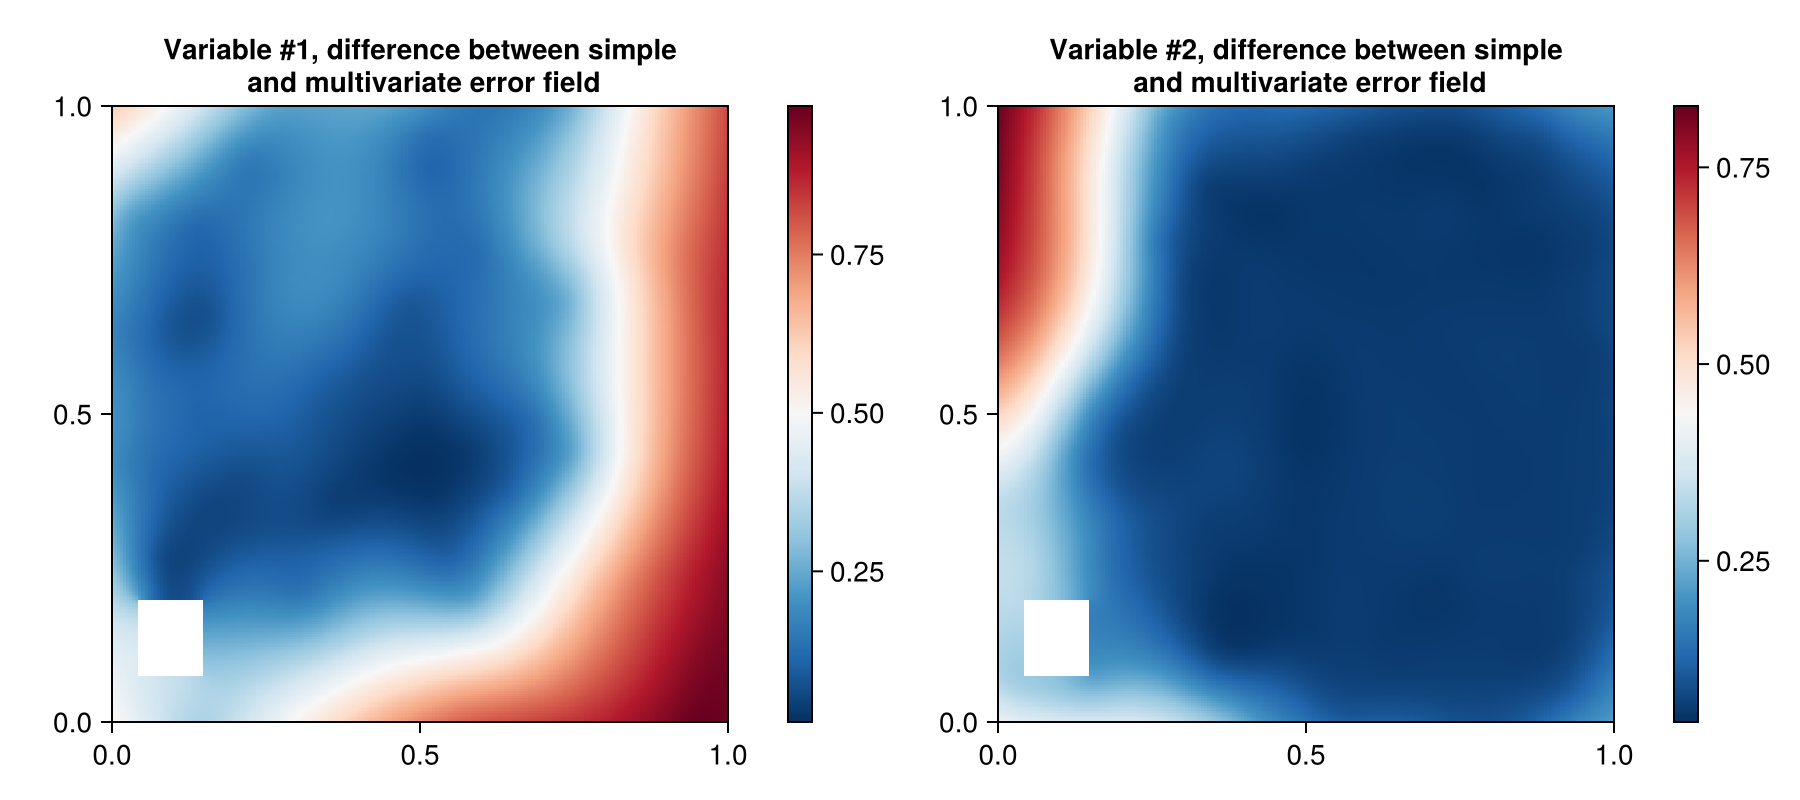

In [13]:
fig = Figure(size = (900, 400))
ax = Axis(
    fig[1, 1],
    aspect = 1,
    title = "Variable #1, difference between simple\n and multivariate error field",
)
hm = heatmap!(
    ax,
    xi[:, 1, 1],
    yi[1, :, 1],
    emap[:, :, 1] - emapm[:, :, 1],
    colormap = Reverse(:RdBu),
)
xlims!(ax, 0, 1)
ylims!(ax, 0, 1)
Colorbar(fig[1, 2], hm)

ax2 = Axis(
    fig[1, 3],
    aspect = 1,
    title = "Variable #2, difference between simple\n and multivariate error field",
)
hm2 = heatmap!(
    ax2,
    xi[:, 1, 1],
    yi[1, :, 1],
    emap[:, :, 2] - emapm[:, :, 2],
    colormap = Reverse(:RdBu),
)
Colorbar(fig[1, 4], hm2)
xlims!(ax2, 0, 1)
ylims!(ax2, 0, 1)
fig

## Display the pseudovelocity field
The last output `pv` of 
[`DIVAnd_multivarJAC`](https://github.com/gher-uliege/DIVAnd.jl/blob/master/src/DIVAnd_multivarJAC.jl) provides an _advection_ field that _guided_ the analysis.

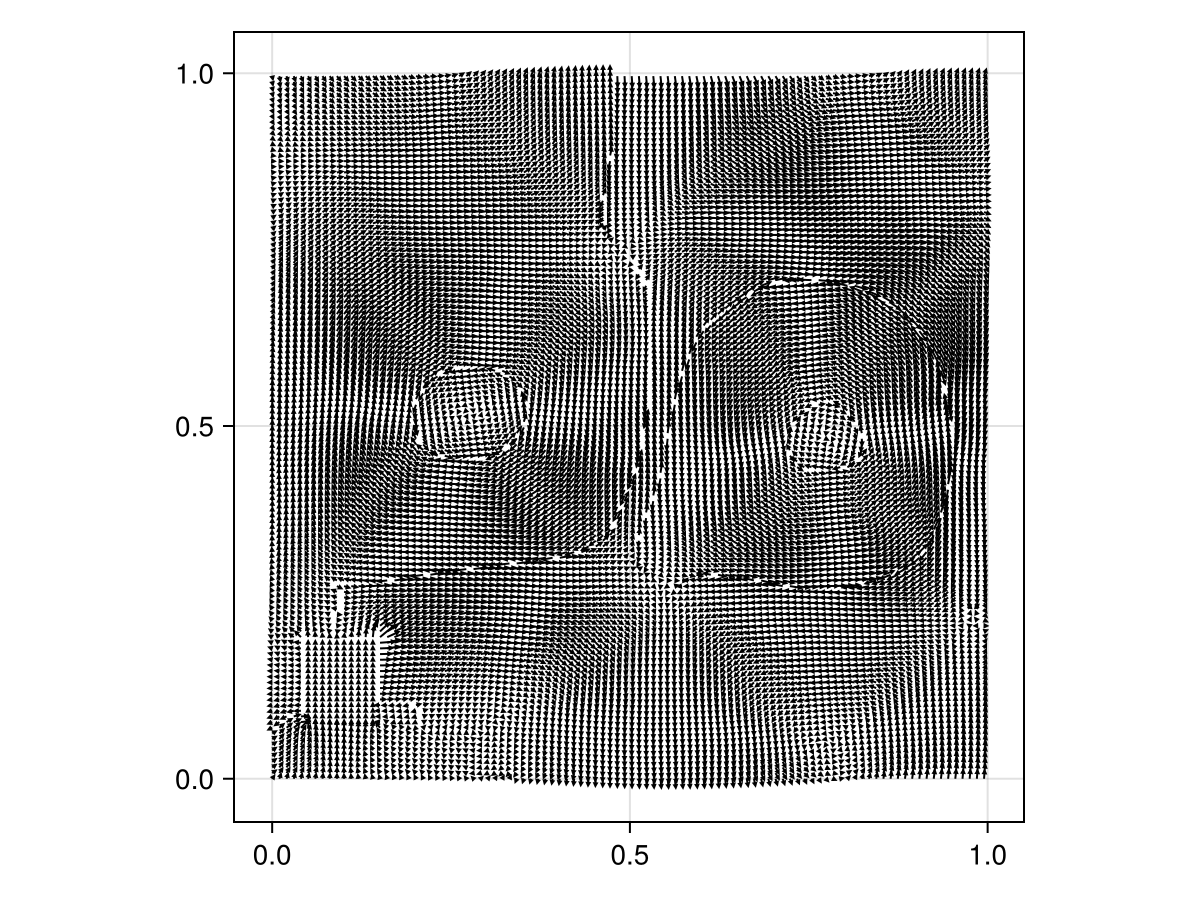

In [14]:
fig = Figure();
r = 2;
ax = Axis(fig[1, 1], aspect = 1, title = "")
arrows!(
    ax,
    xi[1:r:end, 1, 1],
    yi[1, 1:r:end, 1],
    pv[1][1:r:end, 1:r:end, 1],
    pv[2][1:r:end, 1:r:end, 1],
    arrowsize = 4,
    lengthscale = 0.05,
)
fig

In [15]:
@show var(pv[1][:, :, 1]), var(pv[1][:, :, 2])

(var((pv[1])[:, :, 1]), var((pv[1])[:, :, 2])) = (0.019464496552623927, 0.0019464496552623937)


(0.019464496552623927, 0.0019464496552623937)